In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings

import torch
# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

In [2]:
TruePrior = StarPrior(max_objects = 40,
                      image_height = 32,
                      image_width = 32,
                      min_flux = 10000)

TrueImageModel = ImageModel(image_height = 32,
                            image_width = 32,
                            psf_stdev = 0.75,
                            background = 20000)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

image 1 
count
 6 
total flux
 608132.125 
loc
 [[ 7.3394713 22.027449 ]
 [31.535934  11.590432 ]
 [25.361715   7.989057 ]
 [25.571806  19.153982 ]
 [31.025438  21.303932 ]
 [17.994614  11.545204 ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [

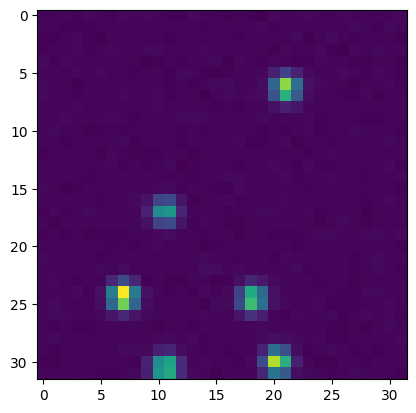

In [3]:
for i in range(1):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

In [4]:
tile_dim = 4

TilePrior = StarPrior(max_objects = 3,
                      image_height = tile_dim,
                      image_width = tile_dim,
                      min_flux = 10000,
                      pad = 2)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = 0.75,
                            background = 20000)

MHKernel = MetropolisHastings(num_iters = 100,
                              locs_stdev = 0.1,
                              features_stdev = 2000)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [5]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 1000,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 6
True total flux: 608132.125

Starting the tile samplers...
iteration 5, temperature = 0.0016810335218906403
iteration 10, temperature = 0.09123517572879791
Done!

summary
number of SMC iterations: 13
posterior mean count by tile:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6600, 0.6200, 0.0000, 1.0000, 0.1700, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0800, 0.0000, 1.0000, 0.0000, 0.0000]],
       device='cuda:5')


In [6]:
smc.counts.sum([0,1]).float().mean()

tensor(6.6513, device='cuda:5')

In [7]:
from smc.aggregate import Aggregate

In [8]:
agg = Aggregate(smc.Prior,
                smc.ImageModel,
                smc.tiled_image,
                smc.counts,
                smc.locs,
                smc.features,
                smc.weights_intercount)

In [9]:
agg.run()
print(agg.counts.sum([0,1]).float().mean())

tensor(5.6570, device='cuda:5')


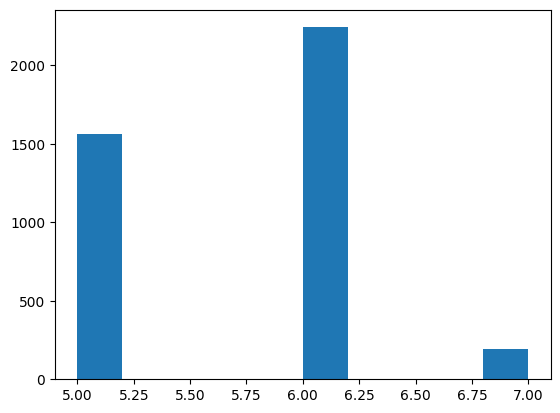

In [10]:
_ = plt.hist(agg.counts.sum([0,1]).cpu())